In [ ]:
!pip install pykan

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.1/78.1 kB 2.2 MB/s eta 0:00:00


In [ ]:
# ===================================================================
#   CELL 1: SETUP, SIMULATION, AND RESULT STORAGE
# ===================================================================
# This cell runs the entire pipeline: data generation, model training,
# and closed-loop evaluation. All results are saved into the
# `simulation_results` dictionary to be used for plotting in Cell 2.
# ===================================================================

# --- 1. SETUP AND IMPORTS ----------------------------------------
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import gamma
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from tqdm import tqdm
import warnings
import torch
from kan import KAN

warnings.filterwarnings('ignore', category=UserWarning)

# --- 2. SYSTEM AND SIMULATION FUNCTIONS --------------------------
def gl_weights(q, L):
    """Calculates Grünwald-Letnikov fractional-order derivative weights."""
    w = np.zeros(L + 1); w[0] = 1
    for k in range(1, L + 1): w[k] = w[k - 1] * (k - 1 - q) / k
    return w

def f_slip_ground_truth(q, state, omega_cmd, kappa, beta):
    """Ground truth nonlinear wheel slip function."""
    _x, _y, _theta, v = state
    return kappa * v * np.tanh(beta * np.abs(omega_cmd))

def robot_step(q, x_current, u_cmd, x_hist, w_gl, h, slip_params):
    """Simulates one step of the fractional-order robot dynamics."""
    kappa, beta = slip_params; _x, _y, theta, v = x_current; omega_cmd, a_cmd = u_cmd
    Dq_X = (1/h**q) * np.dot(w_gl, x_hist)
    rates = np.array([v * np.cos(theta), v * np.sin(theta), omega_cmd,
                      -v + f_slip_ground_truth(q, x_current, omega_cmd, kappa, beta) + a_cmd])
    x_new = x_current + h**q * (rates - Dq_X)
    return x_new

# --- 3. PATH GENERATION AND CONTROLLER -----------------------------
def generate_figure8_path(num_points=1000, scale=4):
    """Generates a figure-8 reference path."""
    t = np.linspace(0, 2 * np.pi, num_points)
    x_ref = scale * np.sin(t); y_ref = scale * np.sin(t) * np.cos(t)
    return np.vstack([x_ref, y_ref]).T

def path_follower_controller(current_state, ref_path, lookahead_dist=0.5):
    """A simple pure-pursuit path following controller."""
    x, y, theta, _v = current_state
    distances_sq = (ref_path[:, 0] - x)**2 + (ref_path[:, 1] - y)**2
    closest_idx = np.argmin(distances_sq)
    lookahead_idx = closest_idx
    while lookahead_idx < len(ref_path) - 1:
        dist_from_closest = np.linalg.norm(ref_path[lookahead_idx] - ref_path[closest_idx])
        if dist_from_closest >= lookahead_dist: break
        lookahead_idx += 1
    x_lookahead, y_lookahead = ref_path[lookahead_idx]
    alpha = np.arctan2(y_lookahead - y, x_lookahead - x)
    angle_diff = np.arctan2(np.sin(alpha - theta), np.cos(alpha - theta))
    omega_d = 2.0 * angle_diff
    e_lat = np.sqrt(distances_sq[closest_idx])
    return omega_d, e_lat

# --- 4. MAIN EXECUTION PIPELINE ------------------------------------
def run_all_simulations():
    """
    Executes the entire data collection, training, and evaluation pipeline.
    Returns a dictionary containing all results needed for analysis and plotting.
    """
    # Dictionary to store all results
    results = {}

    # C1. Data-collection phase
    print("--- C1. Data Collection Phase ---")
    np.random.seed(42)
    q = 0.8; h = 0.02; T_mem = 3.0; Lmem = int(T_mem / h)
    N_paths = 25; T_path = 40.0; w_gl = gl_weights(q, Lmem)
    X_all, Y_all, F_slip_ground_truth_all = [], [], []
    for i in tqdm(range(N_paths), desc="Generating Data"):
        kappa = 0.15 * (1 + (np.random.rand() - 0.5) * 0.4)
        beta = 4.0 * (1 + (np.random.rand() - 0.5) * 0.4)
        slip_params = (kappa, beta)
        x_hist = np.zeros((Lmem + 1, 4))
        for k in range(int(T_path / h)):
            t = k*h
            omega_cmd = 0.8 * np.sin(0.7 * t + i) + 0.4 * np.sin(1.8*t)
            a_cmd = 0.3 * np.sin(0.4 * t - i) + 0.15 * np.cos(1.3*t)
            x_new = robot_step(q,x_hist[0, :], [omega_cmd, a_cmd], x_hist, w_gl, h, slip_params)
            x_hist = np.vstack([x_new, x_hist[:-1, :]])
            Dq_v = (1/h**q) * np.dot(w_gl, x_hist[:, 3])
            y_target = Dq_v + x_hist[0, 3] - a_cmd
            X_all.append(x_hist[0, :]); Y_all.append(y_target)
            F_slip_ground_truth_all.append(f_slip_ground_truth(q,x_hist[0,:], omega_cmd, kappa, beta))
    X_all = np.array(X_all); Y_all = np.array(Y_all).reshape(-1, 1)
    F_slip_ground_truth_all = np.array(F_slip_ground_truth_all).reshape(-1, 1)

    scaler_X = StandardScaler(); scaler_Y = StandardScaler()
    Xn = scaler_X.fit_transform(X_all); Yn = scaler_Y.fit_transform(Y_all)
    results['scalers'] = {'X': scaler_X, 'Y': scaler_Y}

    X_tr_n, X_te_n, y_tr_n, y_te_n, _, f_slip_te_true = train_test_split(
        Xn, Yn, F_slip_ground_truth_all, test_size=0.15, random_state=42)
    X_tr_n, X_va_n, y_tr_n, y_va_n = train_test_split(
        X_tr_n, y_tr_n, test_size=(0.15/0.85), random_state=42)
    results['test_data'] = {'y_te_n': y_te_n, 'f_slip_te_true': f_slip_te_true}

    # C2. KAN Model learning
    print("\n--- C2. KAN Model Learning Phase ---")
    kan = KAN(width=[4, 12, 1], grid=11, k=3, seed=42)
    dataset = {
        'train_input': torch.from_numpy(X_tr_n).float(), 'train_label': torch.from_numpy(y_tr_n).float(),
        'val_input': torch.from_numpy(X_va_n).float(),   'val_label': torch.from_numpy(y_va_n).float(),
        'test_input': torch.from_numpy(X_te_n).float(),    'test_label': torch.from_numpy(y_te_n).float()
    }
    print("Training KAN...")
    kan.fit(dataset, opt="LBFGS", steps=150, log=25)
    results['kan_model'] = kan

    # C3. Symbolic Regression
    print("\n--- C3. Symbolic Regression for KAN ---")
    kan.prune()
    kan.in_vars = ['x', 'y', 'theta', 'v']; kan.out_vars = ['f_slip']
    try:
        formula = kan.symbolic_formula()[0]; print(f"\nDiscovered Symbolic Formula:\n  f_slip_norm = {formula}")
        results['kan_formula'] = formula
    except Exception as e:
        print(f"\nCould not generate symbolic formula. Error: {e}")
        results['kan_formula'] = "Not found"

    # C4. MLP Model Learning
    print("\nTraining MLP...")
    MLP_spec = {'hidden_layer_sizes': (8, 8)}
    mlp = MLPRegressor(**MLP_spec, activation='relu', solver='adam', learning_rate_init=3e-3, max_iter=200,
                       batch_size=512, n_iter_no_change=20, random_state=42, early_stopping=True,
                       validation_fraction=(0.15/0.85))
    mlp.fit(X_tr_n, y_tr_n.ravel())
    results['mlp_model'] = mlp

    # C5. Identification Accuracy
    print("\n--- C4. Identification Accuracy (Test Set) ---")
    y_kan_pred_n = kan(dataset['test_input']).detach().numpy()
    y_mlp_pred_n = mlp.predict(X_te_n).reshape(-1, 1)
    results['predictions'] = {'kan_n': y_kan_pred_n, 'mlp_n': y_mlp_pred_n}

    mse_kan = mean_squared_error(y_te_n, y_kan_pred_n); r2_kan = r2_score(y_te_n, y_kan_pred_n)
    mse_mlp = mean_squared_error(y_te_n, y_mlp_pred_n); r2_mlp = r2_score(y_te_n, y_mlp_pred_n)
    results['metrics'] = {'kan': {'mse': mse_kan, 'r2': r2_kan}, 'mlp': {'mse': mse_mlp, 'r2': r2_mlp}}
    print(f"{'Model':<6}| {'MSE (Norm.)':<12}| {'R²':<6}")
    print("-" * 28)
    print(f"{'KAN':<6}| {mse_kan:<12.4f}| {r2_kan:.4f}")
    print(f"{'MLP':<6}| {mse_mlp:<12.4f}| {r2_mlp:.4f}")

    # C6. Closed-Loop Evaluation
    print("\n--- C5. Closed-Loop Evaluation ---")
    T_sim = 40.0; v_d = 0.6; Kp, Ki = 1.0, 0.4
    ref_path = generate_figure8_path()
    results['reference_path'] = ref_path

    sim_results_cl = {}
    controllers = {'KAN': kan, 'MLP': mlp, 'None': None}
    for name, model in controllers.items():
        print(f"Simulating with {name} compensation...")
        sim_slip_params = (0.15, 4.0)
        x_hist = np.zeros((Lmem + 1, 4)); x_hist[0, :] = [-0.4, 0.4, np.deg2rad(25), 0]
        log_X = [x_hist[0, :]]; log_e_lat = []; integral_e_v = 0.0

        for k in tqdm(range(int(T_sim / h)), desc=f"Simulating {name}"):
            current_state = x_hist[0, :]
            omega_d, e_lat = path_follower_controller(current_state, ref_path)
            e_v = current_state[3] - v_d; integral_e_v += e_v * h
            a_feedback = -Kp * e_v - Ki * integral_e_v
            f_slip_hat = 0.0
            if model is not None:
                current_state_n = scaler_X.transform(current_state.reshape(1, -1))
                if name == 'KAN':
                    state_tensor = torch.from_numpy(current_state_n).float()
                    f_slip_hat_n = model(state_tensor).detach().numpy()
                else: # MLP
                    f_slip_hat_n = model.predict(current_state_n).reshape(-1, 1)
                f_slip_hat = scaler_Y.inverse_transform(f_slip_hat_n)[0, 0]
            a_cmd = a_feedback - f_slip_hat
            u_cmd = np.array([omega_d, a_cmd])
            x_new = robot_step(q,current_state, u_cmd, x_hist, w_gl, h, sim_slip_params)
            x_hist = np.vstack([x_new, x_hist[:-1, :]])
            log_X.append(x_new); log_e_lat.append(e_lat)

        sim_results_cl[name] = {'trajectory': np.array(log_X),
                                'rms_error': np.sqrt(np.mean(np.array(log_e_lat)**2))}
    results['closed_loop'] = sim_results_cl

    print("\n--- Closed-Loop Path Tracking Performance ---")
    print(f"{'Controller':<25}| {'RMS Lateral Error (m)'}")
    print("-" * 50)
    for name, result in sim_results_cl.items():
        print(f"{name + ' Compensation':<25}| {result['rms_error']:.4f}")

    return results

# --- RUN THE PIPELINE AND STORE RESULTS ---------------------------
# All results from the simulation and training are stored in this dictionary.
simulation_results = run_all_simulations()
print("\n✅ All simulations complete. Results are stored in the 'simulation_results' dictionary.")

--- C1. Data Collection Phase ---


Generating Data: 100%|██████████| 25/25 [00:02<00:00, 10.19it/s]



--- C2. KAN Model Learning Phase ---
checkpoint directory created: ./model
saving model version 0.0
Training KAN...


| train_loss: 3.74e-01 | test_loss: 3.84e-01 | reg: 0.00e+00 | : 100%|█| 150/150 [52:10<00:00, 20.87


saving model version 0.1

--- C3. Symbolic Regression for KAN ---
saving model version 0.2

Discovered Symbolic Formula:
  f_slip_norm = [0]

Training MLP...

--- C4. Identification Accuracy (Test Set) ---
Model | MSE (Norm.) | R²    
----------------------------
KAN   | 0.1468      | 0.8543
MLP   | 0.3124      | 0.6899

--- C5. Closed-Loop Evaluation ---
Simulating with KAN compensation...


Simulating KAN: 100%|██████████| 2000/2000 [00:31<00:00, 64.44it/s]


Simulating with MLP compensation...


Simulating MLP: 100%|██████████| 2000/2000 [00:01<00:00, 1430.98it/s]


Simulating with None compensation...


Simulating None: 100%|██████████| 2000/2000 [00:00<00:00, 5468.85it/s]


--- Closed-Loop Path Tracking Performance ---
Controller               | RMS Lateral Error (m)
--------------------------------------------------
KAN Compensation         | 0.1311
MLP Compensation         | 0.1519
None Compensation        | 0.1500

✅ All simulations complete. Results are stored in the 'simulation_results' dictionary.


<>:68: SyntaxWarning: invalid escape sequence '\h'
<>:68: SyntaxWarning: invalid escape sequence '\h'
/tmp/ipython-input-2961932166.py:68: SyntaxWarning: invalid escape sequence '\h'
  plt.ylabel('Predicted Slip Force $\hat{f}_{slip}$')


Generating Figure 1: Closed-Loop Path Tracking...


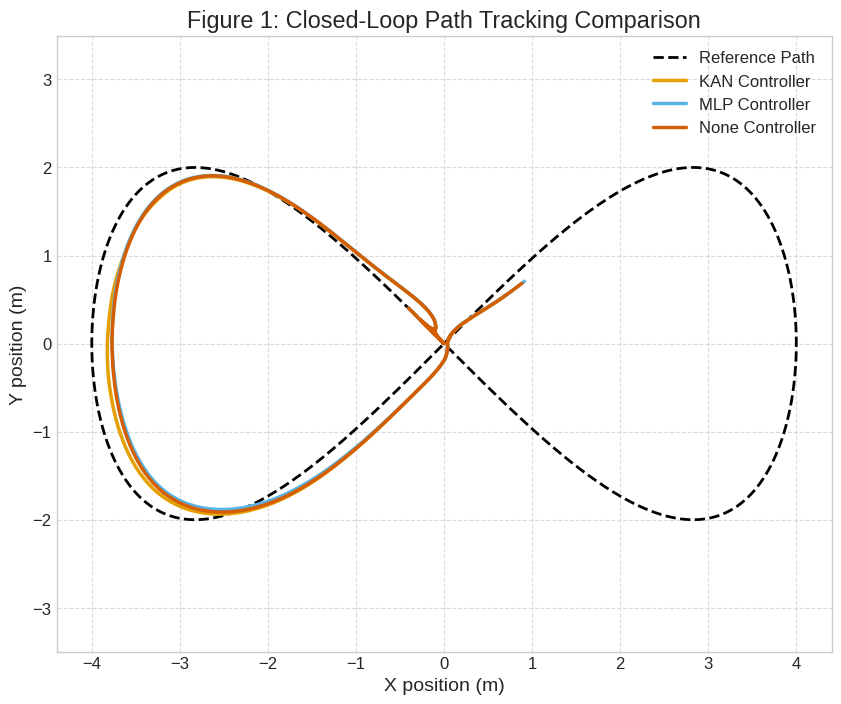


Generating Figure 2: Identification Accuracy...


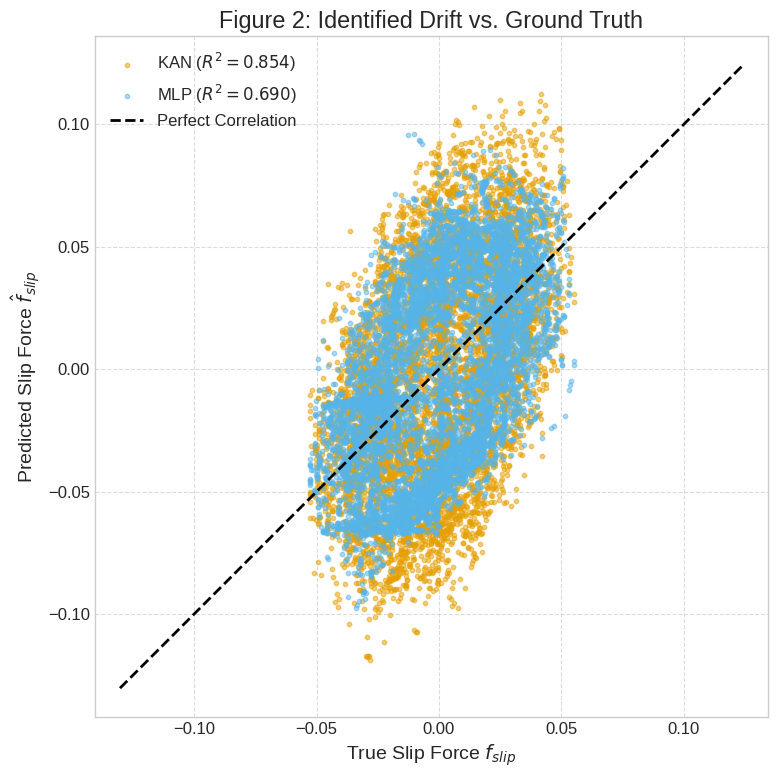

In [ ]:
# ===================================================================
#   CELL 2: VISUALIZATION OF RESULTS
# ===================================================================
# This cell uses the data stored in the `simulation_results`
# dictionary from Cell 1 to generate all plots. You can modify
# and re-run this cell without re-running the simulations.
# ===================================================================

# --- Configure Plot Style ----------------------------------------
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams.update({
    'font.size': 14, 'figure.figsize': (10, 7), 'axes.grid': True,
    'grid.linestyle': '--', 'grid.alpha': 0.7, 'xtick.labelsize': 12,
    'ytick.labelsize': 12, 'legend.fontsize': 12
})

# --- Unpack results from the dictionary for easier access ---
ref_path_to_plot = simulation_results['reference_path']
closed_loop_results = simulation_results['closed_loop']
metrics = simulation_results['metrics']
predictions = simulation_results['predictions']
test_data = simulation_results['test_data']
scaler_Y = simulation_results['scalers']['Y']


# --- Plot 1: Closed-Loop Path Tracking Comparison ---
print("Generating Figure 1: Closed-Loop Path Tracking...")
plt.figure(figsize=(10, 8))
plt.plot(ref_path_to_plot[:, 0], ref_path_to_plot[:, 1], 'k--', lw=2, label='Reference Path')

colors = {'KAN': '#E69F00', 'MLP': '#56B4E9', 'None': '#D55E00'}
for name, result in closed_loop_results.items():
    traj = result['trajectory']
    plt.plot(traj[:, 0], traj[:, 1], label=f'{name} Controller', color=colors[name], lw=2.5)

plt.title('Figure 1: Closed-Loop Path Tracking Comparison')
plt.xlabel('X position (m)')
plt.ylabel('Y position (m)')
plt.legend()
plt.axis('equal')
plt.grid(True)
plt.show()


# --- Plot 2: Identification Accuracy (Predicted vs. True) ---
print("\nGenerating Figure 2: Identification Accuracy...")
# Inverse transform predictions and ground truth to original scale for plotting
y_kan_pred = scaler_Y.inverse_transform(predictions['kan_n'])
y_mlp_pred = scaler_Y.inverse_transform(predictions['mlp_n'])
f_slip_te_true = test_data['f_slip_te_true']

# Get R-squared scores for plot labels
r2_kan = metrics['kan']['r2']
r2_mlp = metrics['mlp']['r2']

plt.figure(figsize=(8, 8))
plt.scatter(f_slip_te_true, y_kan_pred, alpha=0.5, s=10,
            label=f'KAN ($R^2={r2_kan:.3f}$)', color='#E69F00')
plt.scatter(f_slip_te_true, y_mlp_pred, alpha=0.5, s=10,
            label=f'MLP ($R^2={r2_mlp:.3f}$)', color='#56B4E9')

# Plot the y=x line for reference
lims = [min(plt.xlim()[0], plt.ylim()[0]), max(plt.xlim()[1], plt.ylim()[1])]
plt.plot(lims, lims, 'k--', lw=2, label='Perfect Correlation')

plt.title('Figure 2: Identified Drift vs. Ground Truth')
plt.xlabel('True Slip Force $f_{slip}$')
plt.ylabel('Predicted Slip Force $\hat{f}_{slip}$')
plt.legend()
plt.axis('equal')
plt.grid(True)
plt.tight_layout()
plt.show()

<>:85: SyntaxWarning: invalid escape sequence '\h'
<>:85: SyntaxWarning: invalid escape sequence '\h'
/tmp/ipython-input-1182869964.py:85: SyntaxWarning: invalid escape sequence '\h'
  plt.ylabel('Predicted Slip Force $\hat{f}_{slip}$')


Generating Figure 1: Closed-Loop Path Tracking with final inset positions...


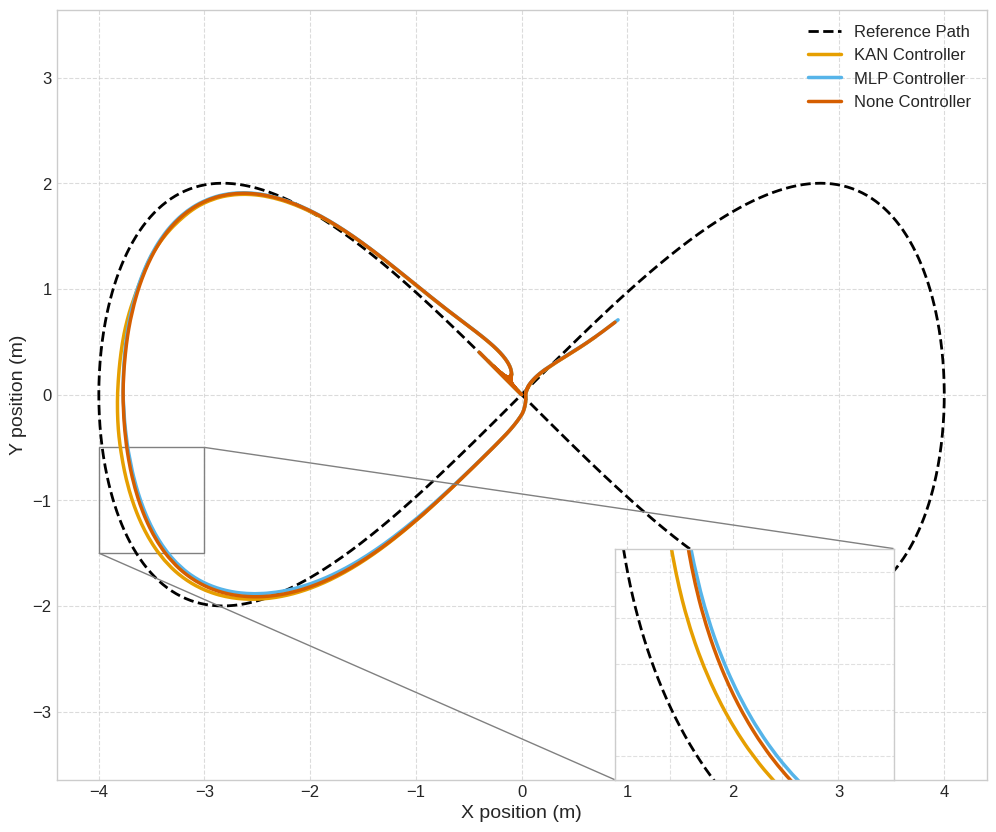


Generating Figure 2: Identification Accuracy...


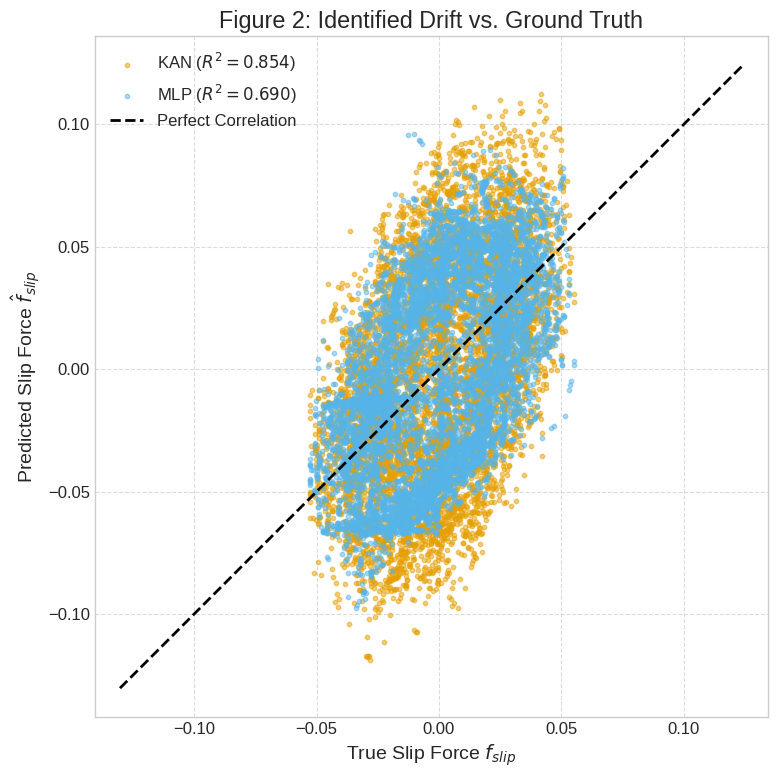

In [ ]:
# ===================================================================
#   CELL 2: VISUALIZATION OF RESULTS (Final Inset Positions)
# ===================================================================
# This cell uses the data stored in the `simulation_results`
# dictionary from Cell 1. The inset positions have been fine-tuned
# to sit in the empty space without overlap.
# ===================================================================

# --- Import additional tools for zoomed plots ---
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

# --- Configure Plot Style ----------------------------------------
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams.update({
    'font.size': 14, 'figure.figsize': (10, 7), 'axes.grid': True,
    'grid.linestyle': '--', 'grid.alpha': 0.7, 'xtick.labelsize': 12,
    'ytick.labelsize': 12, 'legend.fontsize': 12
})

# --- Unpack results from the dictionary for easier access ---
ref_path_to_plot = simulation_results['reference_path']
closed_loop_results = simulation_results['closed_loop']
metrics = simulation_results['metrics']
predictions = simulation_results['predictions']
test_data = simulation_results['test_data']
scaler_Y = simulation_results['scalers']['Y']
colors = {'KAN': '#E69F00', 'MLP': '#56B4E9', 'None': '#D55E00'}


# --- Plot 1: Closed-Loop Path Tracking Comparison with Final Inset Positions ---
print("Generating Figure 1: Closed-Loop Path Tracking with final inset positions...")
fig, ax = plt.subplots(figsize=(12, 10))

# Plot main trajectories on the main axes
ax.plot(ref_path_to_plot[:, 0], ref_path_to_plot[:, 1], 'k--', lw=2, label='Reference Path')
for name, result in closed_loop_results.items():
    traj = result['trajectory']
    ax.plot(traj[:, 0], traj[:, 1], label=f'{name} Controller', color=colors[name], lw=2.5)


# --- Inset 2: Zoom around (-3.5, -1)

axins2 = ax.inset_axes([0.6, 0, 0.3, 0.3])

axins2.plot(ref_path_to_plot[:, 0], ref_path_to_plot[:, 1], 'k--', lw=2)
for name, result in closed_loop_results.items():
    traj = result['trajectory']
    axins2.plot(traj[:, 0], traj[:, 1], color=colors[name], lw=2.5)

x1, x2, y1, y2 = -4.0, -3.0, -1.5, -0.5
axins2.set_xlim(x1, x2)
axins2.set_ylim(y1, y2)
axins2.tick_params(labelleft=False, labelbottom=False)
axins2.grid(linestyle='--', alpha=0.6)
mark_inset(ax, axins2, loc1=1, loc2=3, fc="none", ec="0.5")

# Finalize the main plot

ax.set_xlabel('X position (m)')
ax.set_ylabel('Y position (m)')
ax.legend()
ax.axis('equal')
ax.grid(True)
plt.show()


# --- Plot 2: Identification Accuracy (Predicted vs. True) ---
print("\nGenerating Figure 2: Identification Accuracy...")
y_kan_pred = scaler_Y.inverse_transform(predictions['kan_n'])
y_mlp_pred = scaler_Y.inverse_transform(predictions['mlp_n'])
f_slip_te_true = test_data['f_slip_te_true']
r2_kan = metrics['kan']['r2']
r2_mlp = metrics['mlp']['r2']

plt.figure(figsize=(8, 8))
plt.scatter(f_slip_te_true, y_kan_pred, alpha=0.5, s=10,
            label=f'KAN ($R^2={r2_kan:.3f}$)', color='#E69F00')
plt.scatter(f_slip_te_true, y_mlp_pred, alpha=0.5, s=10,
            label=f'MLP ($R^2={r2_mlp:.3f}$)', color='#56B4E9')

lims = [min(plt.xlim()[0], plt.ylim()[0]), max(plt.xlim()[1], plt.ylim()[1])]
plt.plot(lims, lims, 'k--', lw=2, label='Perfect Correlation')
plt.title('Figure 2: Identified Drift vs. Ground Truth')
plt.xlabel('True Slip Force $f_{slip}$')
plt.ylabel('Predicted Slip Force $\hat{f}_{slip}$')
plt.legend()
plt.axis('equal')
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# ===================================================================
#   CELL 3: Calculate and Display Tracking MSE from Stored Results
# ===================================================================
# This cell uses the RMS error stored in the `simulation_results`
# dictionary from Cell 1 to calculate and display the Mean Squared Error (MSE).
# It does not require re-running any simulations.
# ===================================================================

print("\n--- Closed-Loop Path Tracking Performance (MSE Calculation) ---")
print(f"{'Controller':<25}| {'RMS Lateral Error (m)':<25}| {'MSE Lateral Error (m²)'}")
print("-" * 75)

# Access the results generated by Cell 1
closed_loop_results = simulation_results['closed_loop']

# Iterate through each controller's results
for name, result in closed_loop_results.items():
    # Retrieve the already calculated RMS error
    rms_error = result['rms_error']

    # Calculate MSE directly from RMS error (since MSE = RMS^2)
    mse_error = rms_error ** 2

    # (Optional but good practice) Add the calculated MSE back into the results dictionary
    result['mse_error'] = mse_error

    # Print the formatted output including the new MSE value
    print(f"{name + ' Compensation':<25}| {rms_error:<25.4f}| {mse_error:.4f}")


--- Closed-Loop Path Tracking Performance (MSE Calculation) ---
Controller               | RMS Lateral Error (m)    | MSE Lateral Error (m²)
---------------------------------------------------------------------------
KAN Compensation         | 0.1311                   | 0.0172
MLP Compensation         | 0.1519                   | 0.0231
None Compensation        | 0.1500                   | 0.0225
